In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

### 1. Reading Data

#### Reading Gene data

In [1]:
data = pd.read_csv("training_variants")

print("Total number of data points:", data.shape[0])
print("Total number of features:", data.shape[1])
print("Features:", data.columns.values)

data.head()

<IPython.core.display.Javascript object>

Total number of data points: 3321
Total number of features: 4
Features: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [14]:
data.shape

(3321, 4)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
data['ID'].is_unique

True

- __ID__ : Unique id of the row used to link the mutation to the clinical evidence.
- __Gene__ : Gene where this genetic mutation is located.
- __Variation__ : Aminoacid change for this mutation.
- __Class__ : Class this genetic mutation has been classified on. There are total 9 classes.

#### Reading Text data

In [6]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

print('Total number of data points:', data_text.shape[0])
print('Total number of features:', data_text.shape[1])
print('Features:', data_text.columns.values)

data_text.head()

<IPython.core.display.Javascript object>

Total number of data points: 3321
Total number of features: 2
Features: ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [16]:
data_text.shape

(3321, 2)

In [17]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [7]:
data_text['ID'].is_unique

True

### 2. Preprocessing of text

In [11]:
# loading stop words from nltk library

stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    
    if type(total_text) is not int:
        string = ""
        
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [13]:
#text processing stage

start_time = time.process_time()

for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
        
print('Time took for preprocessing the text :',time.process_time() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 27.78125 seconds


In [18]:
# Merging both gene data and text data based on 'ID'

result = pd.merge(data, data_text, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [26]:
result.shape

(3321, 5)

In [27]:
# Missing values

result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [28]:
# Handling missing values

result.loc[result['TEXT'].isnull(), 'TEXT'] = result['Gene'] + ' ' + result['Variation']

In [29]:
result[result['ID'] == 1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [30]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
 4   TEXT       3321 non-null   object
dtypes: int64(2), object(3)
memory usage: 315.7+ KB


In [35]:
result['Class'].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [217]:
result.to_csv("final_data.csv")

### 3. Exploratory Data Analysis

#### 3.1. Splitting data into train, test and cross validation (64:20:16)

In [31]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [32]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### 3.2. Distribution of y_i's in Train, Test and Cross Validation datasets

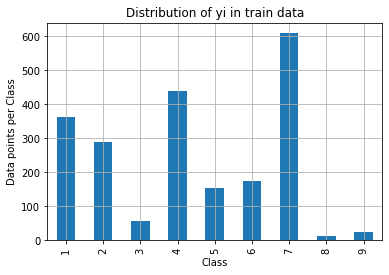

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


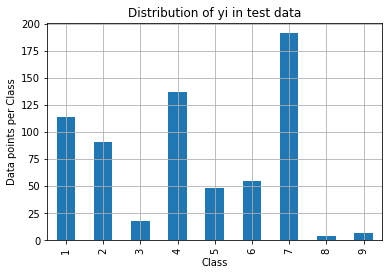

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


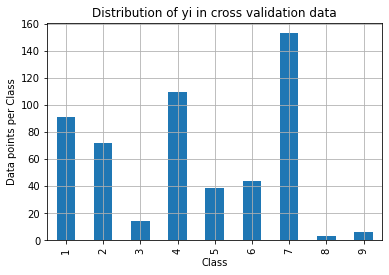

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [36]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


__3.3. Laplace Smoothing__

We're applying Laplace Smoothing when we caculate the probability of a feature belonging to any particular class.
- Laplace Smoothing = (numerator + 10\*alpha) / (denominator + 90\*alpha)

In [44]:
# code for response coding with Laplace smoothing.

# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']

# get_gv_fea_dict: Get Gene varaition Feature Dict

def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
        
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
            # gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])

    return gv_fea

__3.4. Univariate Analysis on 'Gene' Feature__

We'll answer a few Questions related to 'Gene' feature:
1. 'Gene', What type of feature it is ?
2. How many categories are there in 'Gene' and how are they distributed ?
3. How to featurize this 'Gene' feature ?
4. How good is this 'Gene' feature in predicting y_i(true labels) ?
5. Is the 'Gene' feature stable across all the data sets(Test, Train, Cross validation) ?
6. How many data points in Test and CV datasets are covered by the 241 genes in train dataset?

__Q1.__ 'Gene', What type of feature it is ?  
__Ans:__ 'Gene' is a categorical feature.

__Q2.__ How many categories are there in 'Gene' and how are they distributed ?

In [54]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# the top 10 genes that occured most
print(unique_genes.head(10))

print("\nAns: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows:",)

Number of Unique Genes : 241
BRCA1     177
TP53      100
EGFR       95
BRCA2      82
PTEN       81
KIT        62
BRAF       53
ERBB2      51
ALK        43
PDGFRA     40
Name: Gene, dtype: int64

Ans: There are 241 different categories of genes in the train data, and they are distibuted as follows:


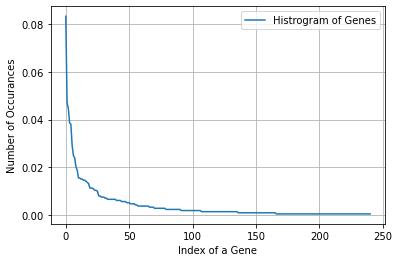

In [68]:
s = sum(unique_genes.values)
h = unique_genes.values/s

plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

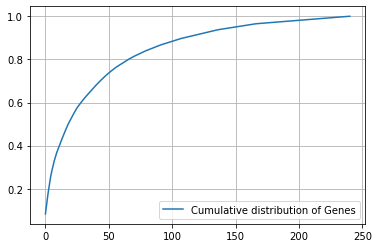

In [70]:
c = np.cumsum(h)

plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

__Q3.__ How to featurize this 'Gene' feature ?  
__Ans:__ There are two ways we can featurize this feature:  
- One Hot Encoding.  
- Response Coding.

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

In [73]:
#response-coding of the Gene feature

# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [74]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [79]:
# one-hot encoding of Gene feature.

gene_vectorizer = CountVectorizer()

train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [84]:
train_df['Gene'].head()

3123    KRAS
1003    TSC1
1549     ALK
414     TP53
229     EGFR
Name: Gene, dtype: object

In [90]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc', 'ar', 'araf',
       'arid1a', 'arid2', 'arid5b', 'asxl1', 'atm', 'atr', 'aurka',
       'aurkb', 'axl', 'b2m', 'bap1', 'bard1', 'bcl10', 'bcl2', 'bcl2l11',
       'bcor', 'braf', 'brca1', 'brca2', 'brd4', 'brip1', 'btk', 'card11',
       'carm1', 'casp8', 'cbl', 'ccnd1', 'ccnd2', 'ccnd3', 'ccne1',
       'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdk8', 'cdkn1a', 'cdkn1b',
       'cdkn2a', 'cdkn2b', 'cdkn2c', 'cebpa', 'chek2', 'cic', 'crebbp',
       'ctcf', 'ctla4', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b',
       'dusp4', 'egfr', 'elf3', 'ep300', 'epas1', 'epcam', 'erbb2',
       'erbb3', 'erbb4', 'ercc2', 'ercc3', 'ercc4', 'erg', 'errfi1',
       'esr1', 'etv1', 'etv6', 'ewsr1', 'ezh2', 'fanca', 'fat1', 'fbxw7',
       'fgf19', 'fgf3', 'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4',
       'flt1', 'flt3', 'foxa1', 'foxl2', 'foxo1', 'foxp1', 'gata3',
       'gli1', 'gna11', 'gnaq', 'gnas', 'h3f3a', 'hist1h1c', 'hla',
       'hnf1

In [91]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 240)


__Q4.__ How good is this 'Gene' feature in predicting y_i?  
__Ans:__ There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.1831108389032008
For values of alpha =  0.0001 The log loss is: 1.1630583887934502
For values of alpha =  0.001 The log loss is: 1.202027525194983
For values of alpha =  0.01 The log loss is: 1.3109278287553452
For values of alpha =  0.1 The log loss is: 1.4337865377403096
For values of alpha =  1 The log loss is: 1.4802921722448592


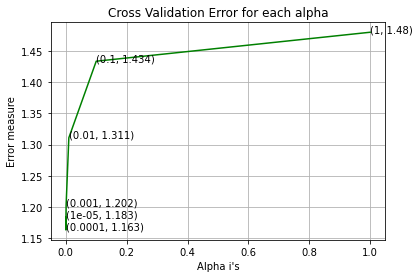

For values of best alpha =  0.0001 The train log loss is: 1.0118105673014204
For values of best alpha =  0.0001 The cross validation log loss is: 1.1630583887934502
For values of best alpha =  0.0001 The test log loss is: 1.1614395515009335


In [92]:
alpha = [10 ** x for x in range(-5, 1)]    # hyperparam for SGD classifier.
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


__Q5.__ Is the 'Gene' feature stable across all the data sets (Test, Train, Cross validation) ?  
__Ans.__ Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

__Q6.__ How many data points in Test and CV datasets are covered by the 241 genes in train dataset?

In [96]:
# print("Q6. How many data points in Test and CV datasets are covered by the", unique_genes.shape[0], "genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans:\n1. In test data',test_coverage, 'out of', test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of', cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Ans:
1. In test data 647 out of 665 : 97.29323308270676
2. In cross validation data 523 out of 532 : 98.30827067669173


__3.5. Univariate Analysis on 'Variation' Feature__

We'll answer a few Questions related to 'Variation' feature:
1. 'Variation', What type of feature it is ?
2. How many categories are there in 'Variation' and how are they distributed ?
3. How to featurize this 'Variation' feature ?
4. How good is this 'Variation' feature in predicting y_i(true labels) ?
5. Is the 'Variation' feature stable across all the data sets(Test, Train, Cross validation) ?
6. How many data points in Test and CV datasets are covered by the 241 genes in train dataset?

__Q1.__ 'Variation', What type of feature it is ?  
__Ans:__ 'Variation' is a categorical feature.

__Q2.__ How many categories are there in 'Gene' and how are they distributed ?

In [102]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])

# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1923
Truncating_Mutations    59
Amplification           52
Deletion                44
Fusions                 25
Overexpression           4
Q61L                     3
G12A                     2
M1R                      2
G13D                     2
E17K                     2
Name: Variation, dtype: int64


In [104]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows:",)

Ans: There are 1923 different categories of variations in the train data, and they are distibuted as follows:


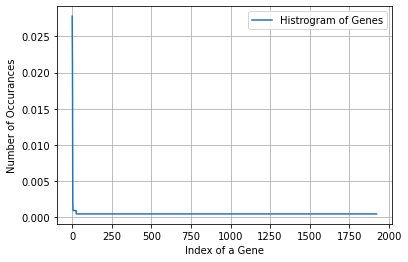

In [105]:
s = sum(unique_variations.values)
h = unique_variations.values/s

plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02777778 0.05225989 0.07297552 ... 0.99905838 0.99952919 1.        ]


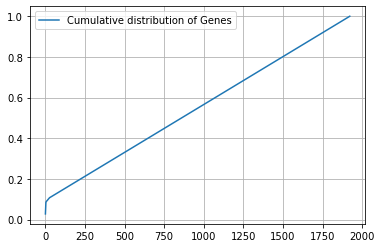

In [107]:
c = np.cumsum(h)

print(c)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

__Q3.__ How to featurize this 'Variation' feature ?  
__Ans:__ There are two ways we can featurize this feature:  
- One Hot Encoding.  
- Response Coding.

We will be using both these methods to featurize the 'Variation' Feature.

In [108]:
#response-coding of the Variation feature

# alpha is used for laplace smoothing
alpha = 1

# train variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))

# test variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))

# cross validation variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [109]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [110]:
# one-hot encoding of variation feature.

variation_vectorizer = CountVectorizer()

train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [112]:
print("train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2124, 1955)


__Q4.__ How good is this 'Variation' feature in predicting y_i?  
__Ans:__ There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Variation feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.7391557896507674
For values of alpha =  0.0001 The log loss is: 1.729092362183494
For values of alpha =  0.001 The log loss is: 1.7403202753613993
For values of alpha =  0.01 The log loss is: 1.7501736545461146
For values of alpha =  0.1 The log loss is: 1.759567018246724
For values of alpha =  1 The log loss is: 1.7615885987492155


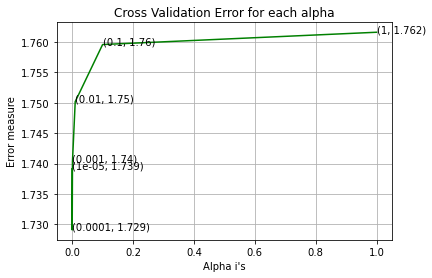

For values of best alpha =  0.0001 The train log loss is: 0.7165142085854902
For values of best alpha =  0.0001 The cross validation log loss is: 1.729092362183494
For values of best alpha =  0.0001 The test log loss is: 1.6882454007816305


In [113]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


__Q5.__ Is the 'Variation' feature stable across all the data sets (Test, Train, Cross validation) ?  
__Ans.__ Not sure! But lets be very sure using the below analysis.

In [ ]:
How many data points are covered by total 1923 genes in test and cross validation data sets?

In [118]:
print("Q6. How many data points are covered by total", unique_variations.shape[0], "variations in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points are covered by total 1923 variations in test and cross validation data sets?
Ans
1. In test data 67 out of 665 : 10.075187969924812
2. In cross validation data 53 out of 532 : 9.962406015037594


__3.6. Univariate Analysis on 'TEXT' Feature__

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [120]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [121]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [124]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data

text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0). A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52729


In [125]:
dict_list = []    # contains 9 dictoinaries each corresponds to a class
 
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [126]:
# response coding of text features

train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [128]:
# we convert each row values such that they sum to 1

train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [129]:
# normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [130]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1], reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [133]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5220, 4: 3434, 5: 2894, 6: 2515, 8: 2267, 9: 1990, 7: 1829, 10: 1500, 11: 1190, 15: 1119, 12: 1013, 14: 952, 16: 850, 13: 803, 18: 657, 20: 585, 17: 577, 21: 541, 23: 526, 24: 487, 19: 465, 22: 457, 28: 411, 30: 407, 27: 375, 25: 361, 32: 331, 44: 320, 33: 314, 26: 300, 31: 276, 36: 271, 29: 269, 54: 266, 35: 237, 40: 226, 34: 225, 42: 214, 38: 202, 45: 187, 37: 187, 43: 186, 39: 182, 48: 181, 50: 171, 46: 163, 64: 160, 41: 159, 49: 158, 52: 155, 47: 146, 57: 139, 56: 139, 60: 131, 55: 131, 72: 129, 53: 120, 66: 116, 51: 112, 62: 110, 58: 110, 63: 109, 75: 106, 61: 105, 65: 104, 59: 104, 69: 98, 67: 98, 73: 96, 80: 95, 78: 94, 70: 86, 74: 84, 68: 83, 90: 80, 76: 78, 79: 75, 85: 73, 71: 73, 108: 72, 120: 70, 96: 70, 88: 70, 101: 69, 77: 69, 84: 67, 81: 67, 94: 66, 83: 65, 87: 64, 99: 63, 92: 63, 91: 63, 112: 62, 86: 61, 109: 60, 105: 59, 82: 59, 93: 58, 98: 57, 89: 56, 115: 55, 106: 55, 110: 53, 97: 53, 95: 53, 100: 51, 123: 47, 142: 45, 107: 45, 154: 44, 119: 44, 113: 44, 1

For values of alpha =  1e-05 The log loss is: 1.2951312844081497
For values of alpha =  0.0001 The log loss is: 1.1911052246346236
For values of alpha =  0.001 The log loss is: 1.181632799188006
For values of alpha =  0.01 The log loss is: 1.2395649968261708
For values of alpha =  0.1 The log loss is: 1.4097161541753012
For values of alpha =  1 The log loss is: 1.650114026480655


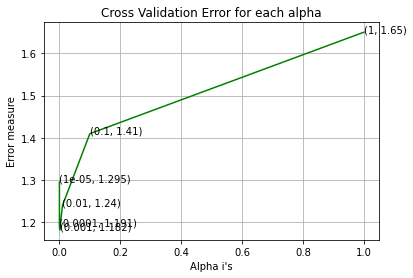

For values of best alpha =  0.001 The train log loss is: 0.6555303173242896
For values of best alpha =  0.001 The cross validation log loss is: 1.181632799188006
For values of best alpha =  0.001 The test log loss is: 1.088514123318682


In [134]:
# Train a Logistic Regression + Calibration Model using text features which are one-hot encoded

alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


__Q__: Is the Text feature stable across all the data sets (Test, Train, Cross validation) ?  
__Ans:__ Yes, it seems like!

In [137]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [138]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")

len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

95.603 % of word of test data appeared in train data
97.6 % of word of Cross Validation appeared in train data


### 4. Machine Learning Models

In [139]:
# This function plots the confusion matrices given y_i, y_i_hat.

def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

__4.1. Random Model__

- In a 'Random' Model, we generate NINE class probabilites randomly such that they sum to 1.

Log loss on Cross Validation Data using Random Model: 2.4520973087362954
Log loss on Test Data using Random Model: 2.4502256053762337
-------------------- Confusion matrix --------------------


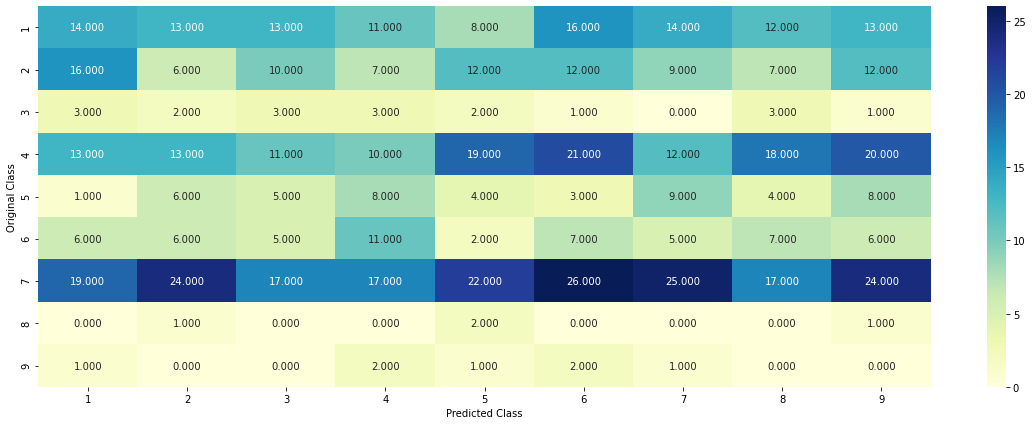

-------------------- Precision matrix (Columm Sum=1) --------------------


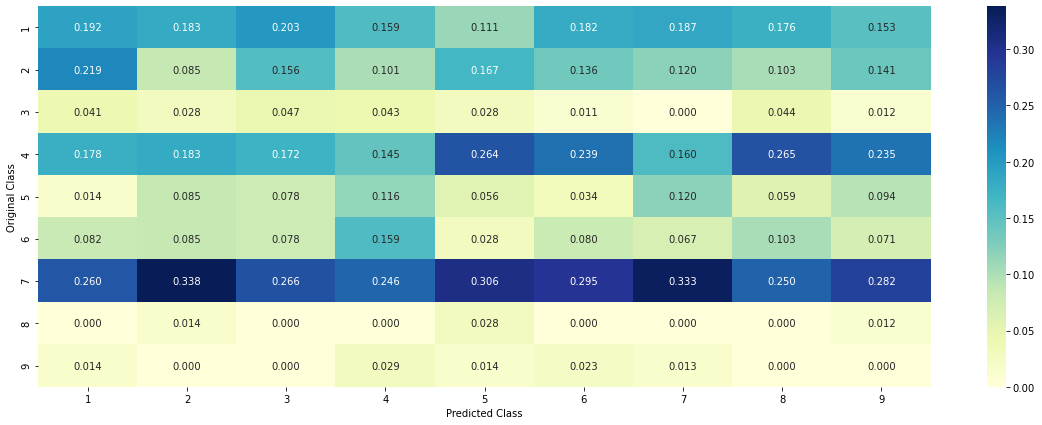

-------------------- Recall matrix (Row sum=1) --------------------


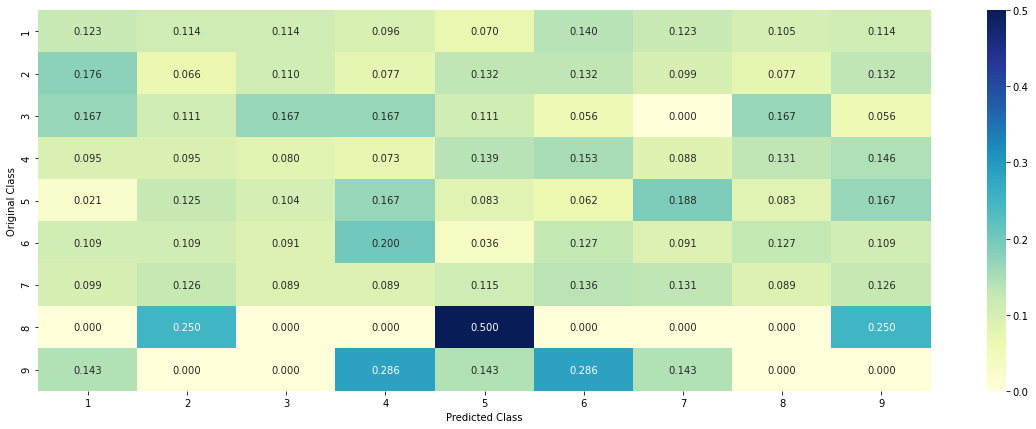

In [141]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model:",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
# we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model:",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [144]:
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :", log_loss(test_y, sig_clf.predict_proba(test_x)))
    
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y-test_y))/test_y.shape[0])
    
    plot_confusion_matrix(test_y, pred_y)

In [145]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [146]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ", no_features, " features ", word_present, "are present in query point")

In [148]:
# merging Gene, Variation and TEXT features (One-Hot Encoding)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding, train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [149]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54924)
(number of data points * number of features) in test data =  (665, 54924)
(number of data points * number of features) in cross validation data = (532, 54924)


In [150]:
# merging Gene, Variation and TEXT features (Response Coding)

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding, train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding, test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding, cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [151]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


__4.2. Naive Bayes__

- Hyper parameter tuning (NB) :

for alpha = 1e-05
Log Loss : 1.2859647259905127
for alpha = 0.0001
Log Loss : 1.2770856227673888
for alpha = 0.001
Log Loss : 1.2653535628476873
for alpha = 0.1
Log Loss : 1.280037693075265
for alpha = 1
Log Loss : 1.278722001019694
for alpha = 10
Log Loss : 1.3859999593142105
for alpha = 100
Log Loss : 1.3895538712161368
for alpha = 1000
Log Loss : 1.2975589824803848


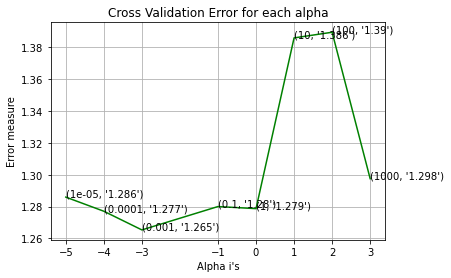

For values of best alpha =  0.001 The train log loss is: 0.8448806729644716
For values of best alpha =  0.001 The cross validation log loss is: 1.2653535628476873
For values of best alpha =  0.001 The test log loss is: 1.2442205809454645


In [152]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


- Testing the model with best hyper paramters (Naive Bayes) :

Log Loss : 1.2653535628476873
Number of missclassified point : 0.40601503759398494
-------------------- Confusion matrix --------------------


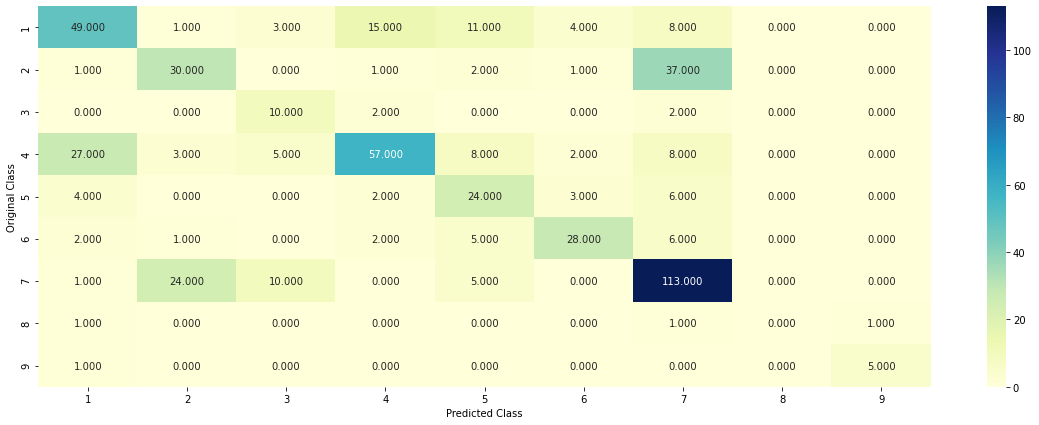

-------------------- Precision matrix (Columm Sum=1) --------------------


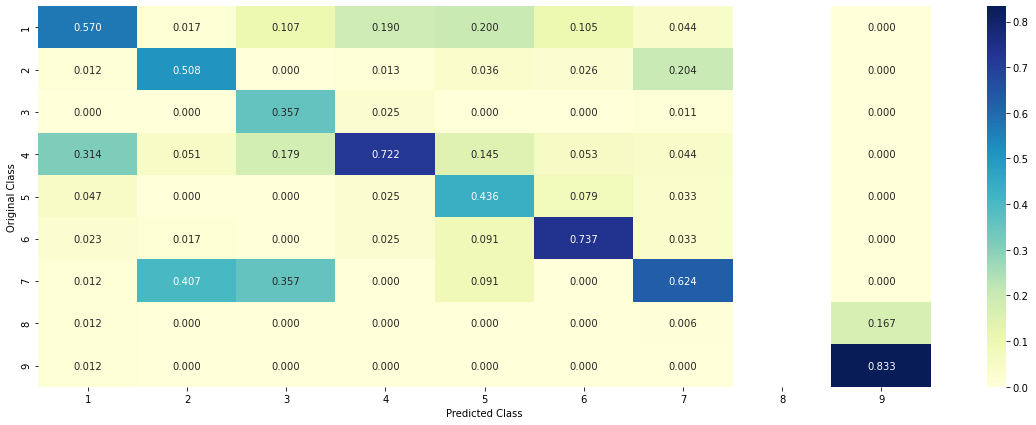

-------------------- Recall matrix (Row sum=1) --------------------


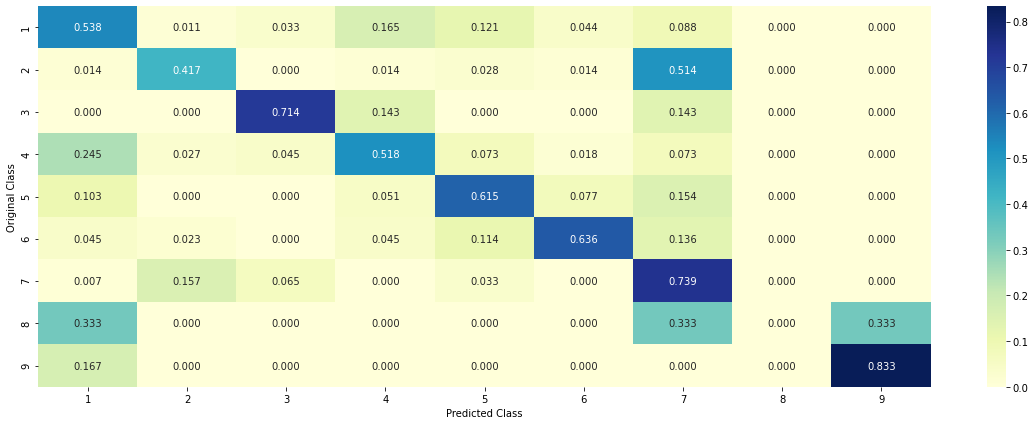

In [153]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)-cv_y))/cv_y.shape[0])

plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

- Feature Importance, Correctly classified points (Naive Bayes) :

In [155]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices=np.argsort(-1*clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0894 0.083  0.0139 0.1104 0.0361 0.0412 0.6169 0.0055 0.0037]]
Actual Class : 7
--------------------------------------------------
16 Text feature [kinase] present in test data point [True]
17 Text feature [inhibitor] present in test data point [True]
19 Text feature [presence] present in test data point [True]
20 Text feature [activating] present in test data point [True]
23 Text feature [independent] present in test data point [True]
25 Text feature [recently] present in test data point [True]
26 Text feature [cell] present in test data point [True]
27 Text feature [shown] present in test data point [True]
28 Text feature [contrast] present in test data point [True]
30 Text feature [previously] present in test data point [True]
31 Text feature [cells] present in test data point [True]
32 Text feature [obtained] present in test data point [True]
33 Text feature [expressing] present in test data point [True]
36 Text feature [growth

In [156]:
test_df['TEXT'].iloc[test_point_index]

'systemic mastocytosis sm rare disease caused abnormal mast cell accumulation various tissues two classes constitutive activating c kit mutations found sm frequent class occurs catalytic pocket coding region substitutions codon 816 intracellular juxtamembrane coding region therefore kinase inhibitors block mutated c kit activity might used therapeutic agents sm show sti571 inhibits wild type juxtamembrane mutant c kit kinase activity effect activity d816 v mutant accordingly sti571 selectively decreases survival normal mast cell mast cell lines either juxtamembrane c kit mutations tumoral mast cell patient sm mast cell lines d816 v mutation therefore sti571 good candidate treat sm specific kinase inhibitors designed inhibit constitutive activating mutations codon 816 keywords mastocytosis c kit sti571 kinase inhibitor top page introduction systemic mastocytosis sm neoplastic disease caused abnormal mast cell mc migration survival proliferation activation longley et al 1995 recent studi

In [166]:
test_df['Gene'].iloc[test_point_index]

'KIT'

In [168]:
test_df['Variation'].iloc[test_point_index]

'D814V'

In [169]:
clf.feature_log_prob_.shape

(9, 54924)

In [175]:
indices = np.argsort(-1 * abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]

print(indices.shape)
indices

(1, 100)


array([[27461, 35764, 35763, 35762, 35759, 35758, 35757, 35755, 12064,
        35753, 12066, 35752, 35751, 35747, 35746, 35734, 35730, 12074,
        35725, 35719, 35718, 35717, 35705, 12087, 12090, 35703, 12092,
        35702, 35767, 35768, 35770, 35777, 12011, 35853, 35852, 35851,
        35848, 35846, 20135, 35841, 35839, 12024, 35838, 35836, 35835,
        12094, 35833, 35825, 35822, 35820, 35806, 35804, 35802, 12038,
        35796, 35795, 35789, 12044, 35780, 20134, 35832, 35699, 35693,
        35683, 35621, 35611, 35610, 35609, 35608, 35607, 35606, 12153,
        35605, 35592, 35589, 35585, 12166, 12145, 12167, 12169, 12170,
        35584, 35578, 35573, 12176, 12178, 12180, 12181, 12182, 35561,
        35558, 35556, 12168, 35856, 35624, 20130, 35682, 35680, 35678,
        12104]], dtype=int64)

In [176]:
print(indices[0].shape)
indices[0]

(100,)


array([27461, 35764, 35763, 35762, 35759, 35758, 35757, 35755, 12064,
       35753, 12066, 35752, 35751, 35747, 35746, 35734, 35730, 12074,
       35725, 35719, 35718, 35717, 35705, 12087, 12090, 35703, 12092,
       35702, 35767, 35768, 35770, 35777, 12011, 35853, 35852, 35851,
       35848, 35846, 20135, 35841, 35839, 12024, 35838, 35836, 35835,
       12094, 35833, 35825, 35822, 35820, 35806, 35804, 35802, 12038,
       35796, 35795, 35789, 12044, 35780, 20134, 35832, 35699, 35693,
       35683, 35621, 35611, 35610, 35609, 35608, 35607, 35606, 12153,
       35605, 35592, 35589, 35585, 12166, 12145, 12167, 12169, 12170,
       35584, 35578, 35573, 12176, 12178, 12180, 12181, 12182, 35561,
       35558, 35556, 12168, 35856, 35624, 20130, 35682, 35680, 35678,
       12104], dtype=int64)

In [177]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature is present in the test point text or not

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ", no_features," features ", word_present, "are present in query point")

In [178]:
for i in range(10):
    test_point_index = i
    no_feature = 100
    predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
    
    print("Predicted Class :", predicted_cls[0])
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
    print("Actual Class :", test_y[test_point_index])
    
    indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
    print("-"*50)
    get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index].lower(),test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0886 0.0822 0.0137 0.1096 0.0357 0.2369 0.424  0.0055 0.0037]]
Actual Class : 6
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 7
Predicted Class Probabilities: [[0.0894 0.083  0.0139 0.1104 0.0361 0.0412 0.6169 0.0055 0.0037]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 5
Predicted Class Probabilities: [[0.1131 0.1045 0.0769 0.1383 0.3573 0.0517 0.1466 0.0069 0.0047]]
Actual Class : 6
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 4
Predicted Class Probabilities: [[0.0801 0.0744 0.0125 0.6511 0.0323 0.0369 0.1044 0.0049 0.0034]]
Actual Class : 3
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class 

- Feature Importance, Incorrectly classified points (Naive Bayes) :

In [179]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 5
Predicted Class Probabilities: [[0.1128 0.1042 0.0175 0.138  0.4182 0.0516 0.1462 0.0069 0.0047]]
Actual Class : 5
--------------------------------------------------
Out of the top  100  features  0 are present in query point


__4.3. KNN__

- Hyper parameter tuning (KNN) :

for alpha = 5
Log Loss : 1.0454341266554459
for alpha = 11
Log Loss : 1.0374240821932452
for alpha = 15
Log Loss : 1.0324750127499454
for alpha = 21
Log Loss : 1.0462813308536207
for alpha = 31
Log Loss : 1.0680942243084024
for alpha = 41
Log Loss : 1.0794706246888912
for alpha = 51
Log Loss : 1.0849172539229206
for alpha = 99
Log Loss : 1.1132243714163939


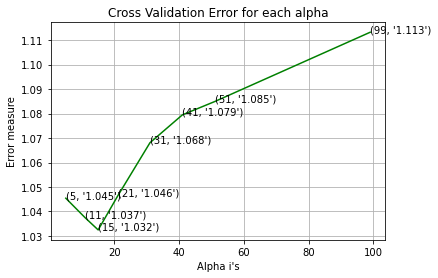

For values of best alpha =  15 The train log loss is: 0.6741367202853
For values of best alpha =  15 The cross validation log loss is: 1.0324750127499454
For values of best alpha =  15 The test log loss is: 1.0190567363226157


In [180]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


- Testing the model with best hyper paramters (KNN) :

Log loss : 1.0324750127499454
Number of mis-classified points : 0.35902255639097747
-------------------- Confusion matrix --------------------


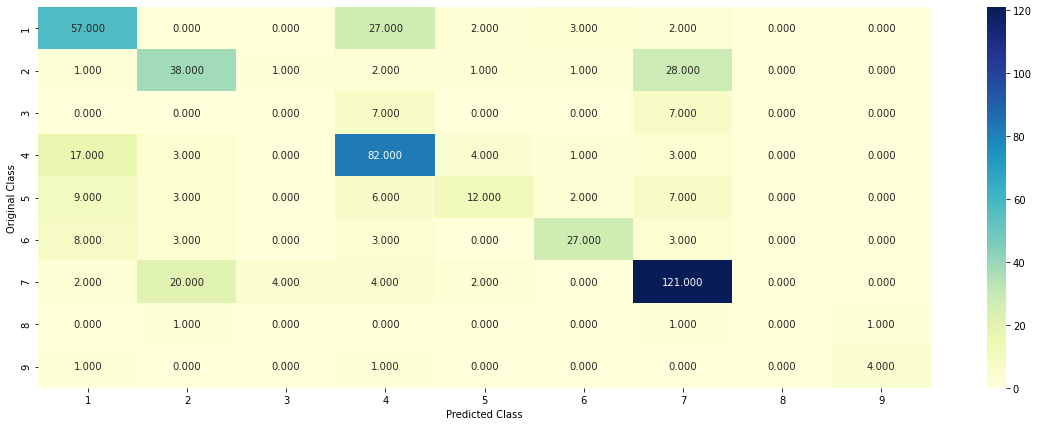

-------------------- Precision matrix (Columm Sum=1) --------------------


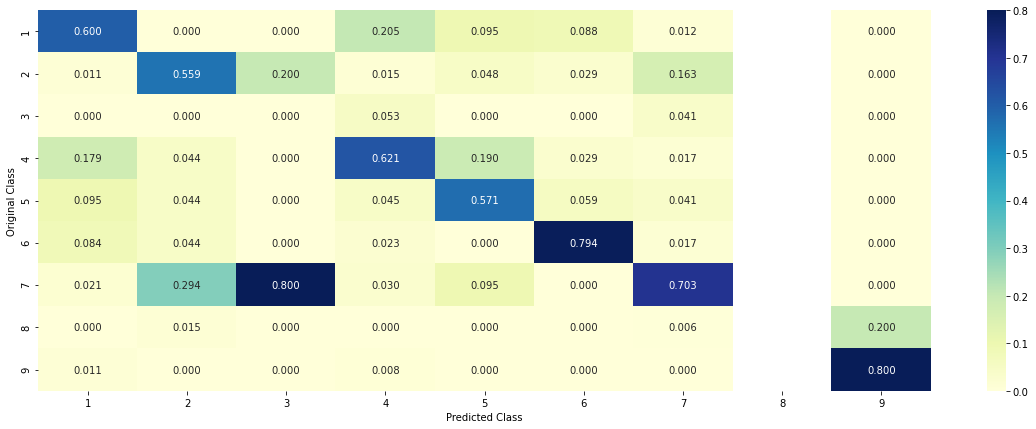

-------------------- Recall matrix (Row sum=1) --------------------


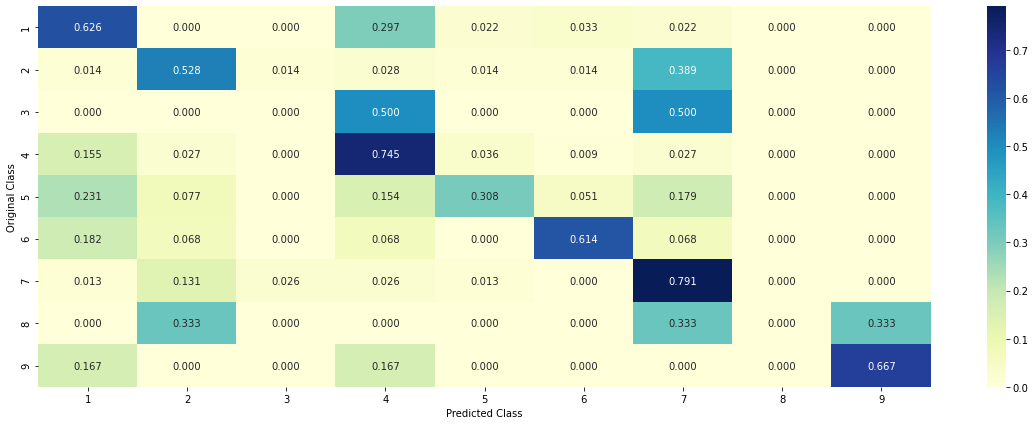

In [181]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

- Sample Query point 1 (KNN) :

In [182]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])

print("The", alpha[best_alpha], "nearest neighbours of the test points belongs to classes", train_y[neighbors[1][0]])
print("Fequency of nearest points :", Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The 15 nearest neighbours of the test points belongs to classes [7 7 7 2 7 7 7 2 7 7 7 7 7 7 7]
Fequency of nearest points : Counter({7: 13, 2: 2})


- Sample Query point 2 (KNN) :

In [184]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])

print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 5
the k value for knn is 15 and the nearest neighbours of the test points belongs to classes [1 1 1 1 5 5 1 1 1 5 5 1 1 5 5]
Fequency of nearest points : Counter({1: 9, 5: 6})


__4.4. Logistic Regression with class balancing__

- Hyper paramter tuning (Logistic Regression & class balancing) :

for alpha = 1e-06
Log Loss : 1.376538940009938
for alpha = 1e-05
Log Loss : 1.3593094240332868
for alpha = 0.0001
Log Loss : 1.160784445645638
for alpha = 0.001
Log Loss : 1.14052398600558
for alpha = 0.01
Log Loss : 1.1476693516381777
for alpha = 0.1
Log Loss : 1.416714649483357
for alpha = 1
Log Loss : 1.660739156442786
for alpha = 10
Log Loss : 1.694440520286355
for alpha = 100
Log Loss : 1.69811094549637


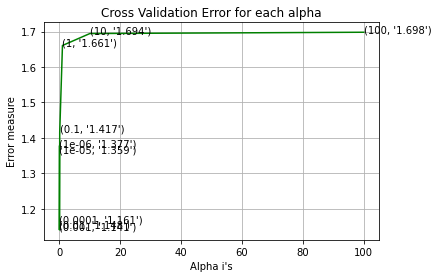

For values of best alpha =  0.001 The train log loss is: 0.5259761232913517
For values of best alpha =  0.001 The cross validation log loss is: 1.14052398600558
For values of best alpha =  0.001 The test log loss is: 0.9862867246826722


In [185]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


- Testing the model with best hyper parameters (Logistic Regression & class balancing) :

Log loss : 1.14052398600558
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


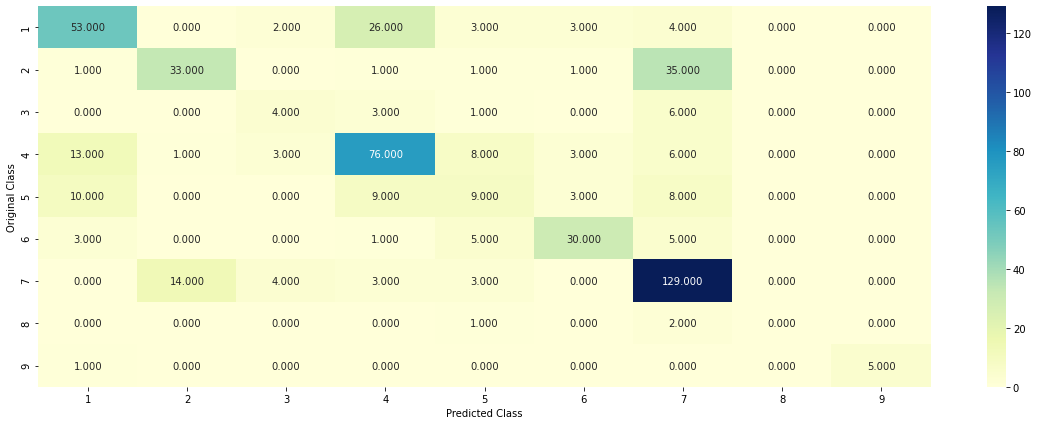

-------------------- Precision matrix (Columm Sum=1) --------------------


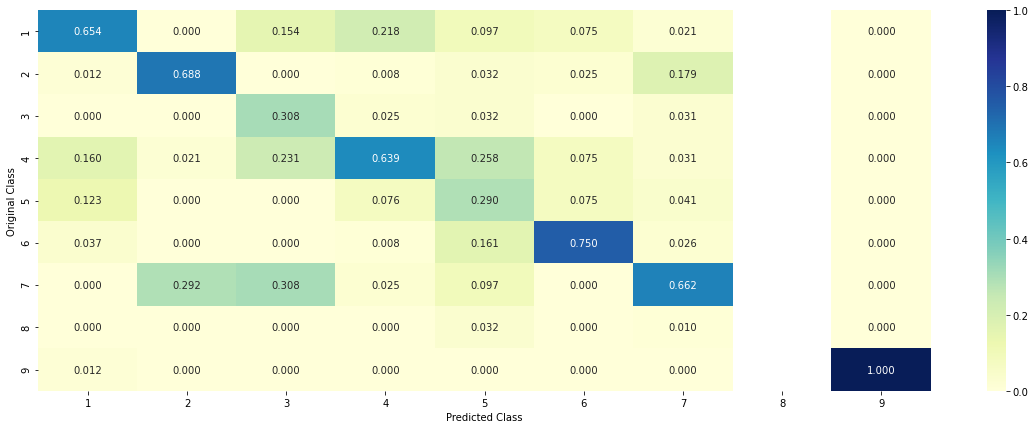

-------------------- Recall matrix (Row sum=1) --------------------


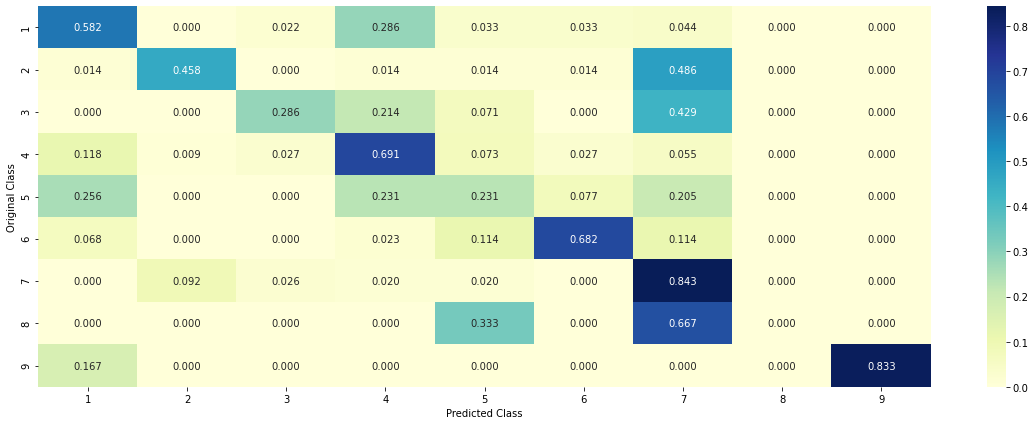

In [186]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

- Feature Importance (Logistic Regression & class balancing) :

In [187]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i < 18:
            tabulte_list.append([incresingorder_ind, "Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind, train_text_features[i], yes_no])
        incresingorder_ind += 1
        
    print(word_present, "most important features are present in our query point")
    print("-"*50)
    print("The features that are most important of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

- Correctly Classified point (Logistic Regression & class balancing) :

In [188]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
# get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)
get_imp_feature_names(test_df['TEXT'].iloc[test_point_index], indices[0])

Predicted Class : 7
Predicted Class Probabilities: [[0.0676 0.1902 0.0228 0.0738 0.034  0.0312 0.5656 0.0066 0.0082]]
Actual Class : 7
--------------------------------------------------
124 Text feature [constitutively] present in test data point [True]
145 Text feature [constitutive] present in test data point [True]
186 Text feature [buchdunger] present in test data point [True]
257 Text feature [activated] present in test data point [True]
Out of the top  500  features  4 are present in query point


- Incorrectly Classified point (Logistic Regression & class balancing) :

In [189]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4465 0.0138 0.0252 0.1272 0.3658 0.0077 0.0065 0.0046 0.0026]]
Actual Class : 5
--------------------------------------------------
309 Text feature [deficient] present in test data point [True]
Out of the top  500  features  1 are present in query point


__4.5. Logistic Regression without class balancing__

- Hyper paramter tuning (Logistic Regression without class balancing) :

for alpha = 1e-06
Log Loss : 1.3534510044616823
for alpha = 1e-05
Log Loss : 1.3198098893950116
for alpha = 0.0001
Log Loss : 1.1628724525437537
for alpha = 0.001
Log Loss : 1.1594765220557202
for alpha = 0.01
Log Loss : 1.2088993744384111
for alpha = 0.1
Log Loss : 1.3298584745204072
for alpha = 1
Log Loss : 1.6023582159755534


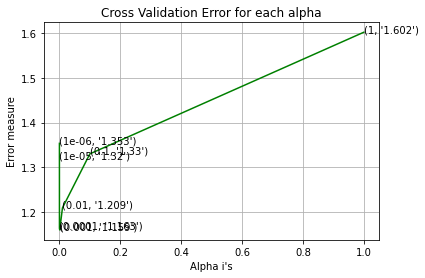

For values of best alpha =  0.001 The train log loss is: 0.5204576483900912
For values of best alpha =  0.001 The cross validation log loss is: 1.1594765220557202
For values of best alpha =  0.001 The test log loss is: 0.9969993637882546


In [190]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


- Testing model with best hyper parameters (Logistic Regression without class balancing) :

Log loss : 1.1594765220557202
Number of mis-classified points : 0.35714285714285715
-------------------- Confusion matrix --------------------


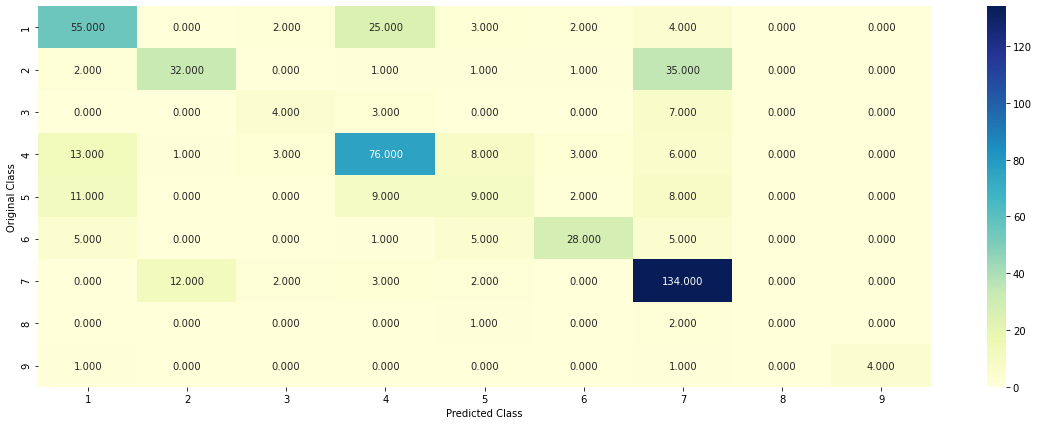

-------------------- Precision matrix (Columm Sum=1) --------------------


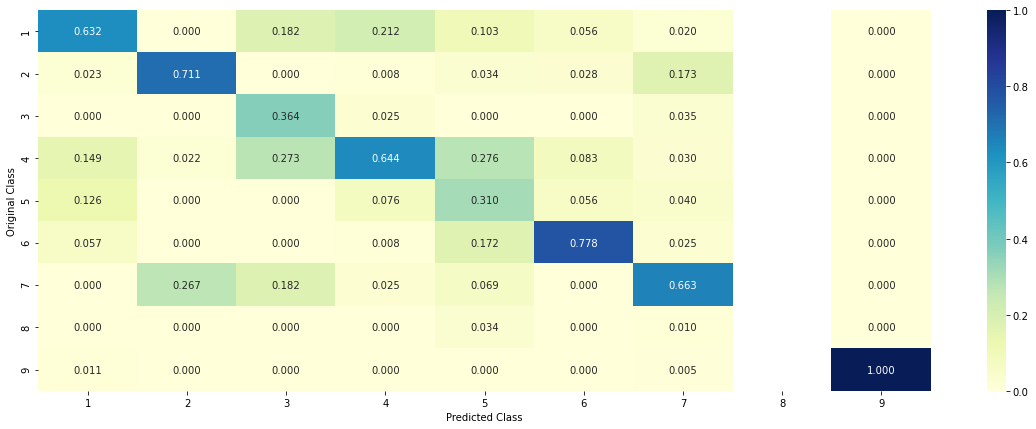

-------------------- Recall matrix (Row sum=1) --------------------


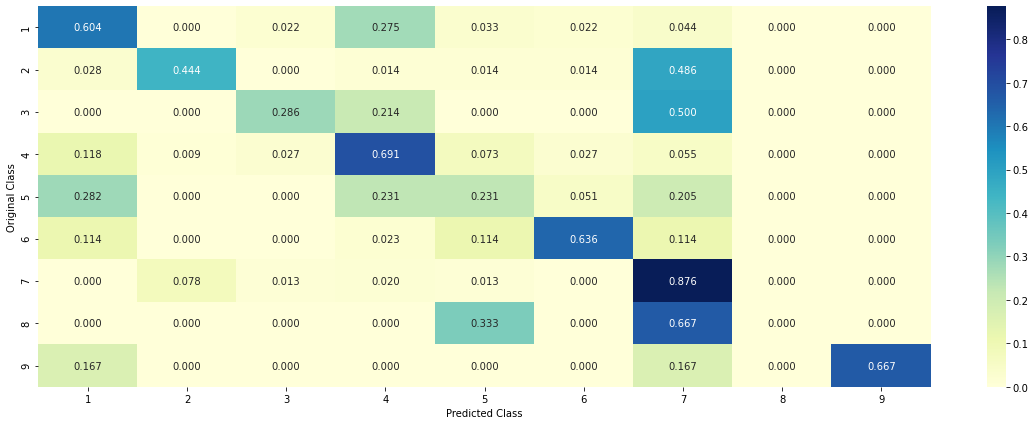

In [191]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

- Feature Importance, Correctly Classified point (Logistic Regression without class balancing) :

In [192]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0648 0.1882 0.0249 0.0676 0.0358 0.0325 0.5699 0.0073 0.0089]]
Actual Class : 7
--------------------------------------------------
223 Text feature [constitutively] present in test data point [True]
259 Text feature [constitutive] present in test data point [True]
353 Text feature [buchdunger] present in test data point [True]
434 Text feature [activated] present in test data point [True]
Out of the top  500  features  4 are present in query point


- Feature Importance, incorrectly Classified point (Logistic Regression without class balancing) :

In [193]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 1
Predicted Class Probabilities: [[0.4648 0.0142 0.0126 0.1577 0.3312 0.0074 0.0077 0.0035 0.0009]]
Actual Class : 5
--------------------------------------------------
416 Text feature [deficient] present in test data point [True]
Out of the top  500  features  1 are present in query point


__4.6. Linear Support Vector Machines__

- Hyper paramter tuning (SVM) :

for C = 1e-05
Log Loss : 1.3437061439248077
for C = 0.0001
Log Loss : 1.2999497511297062
for C = 0.001
Log Loss : 1.1990733452827798
for C = 0.01
Log Loss : 1.1810469261858365
for C = 0.1
Log Loss : 1.3462988608481483
for C = 1
Log Loss : 1.6796785788995265
for C = 10
Log Loss : 1.698705582292905
for C = 100
Log Loss : 1.6987032290405901


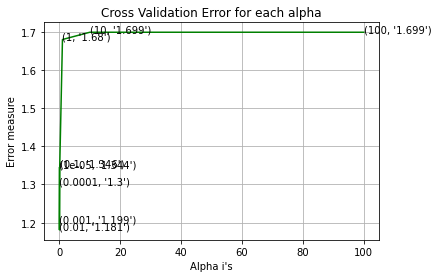

For values of best alpha =  0.01 The train log loss is: 0.7425383726406519
For values of best alpha =  0.01 The cross validation log loss is: 1.1810469261858365
For values of best alpha =  0.01 The test log loss is: 1.0486546192706077


In [194]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


- Testing model with best hyper parameters (SVM) :

Log loss : 1.1810469261858365
Number of mis-classified points : 0.3815789473684211
-------------------- Confusion matrix --------------------


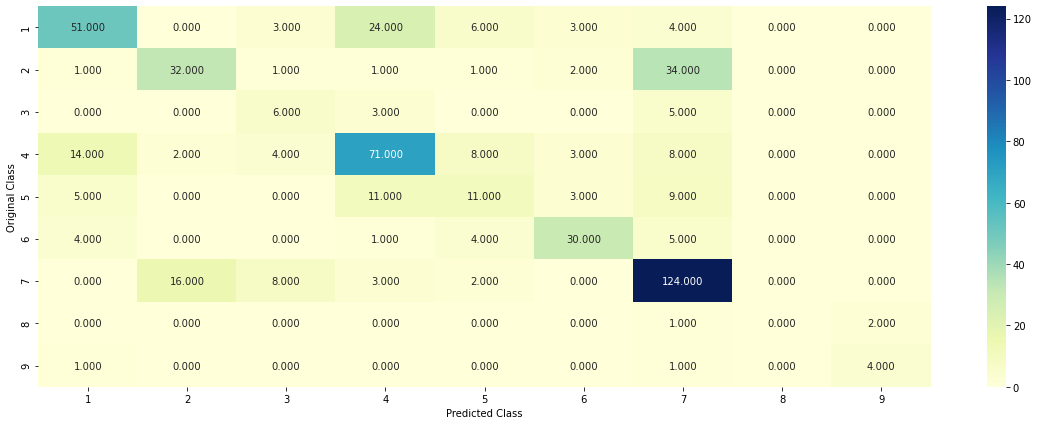

-------------------- Precision matrix (Columm Sum=1) --------------------


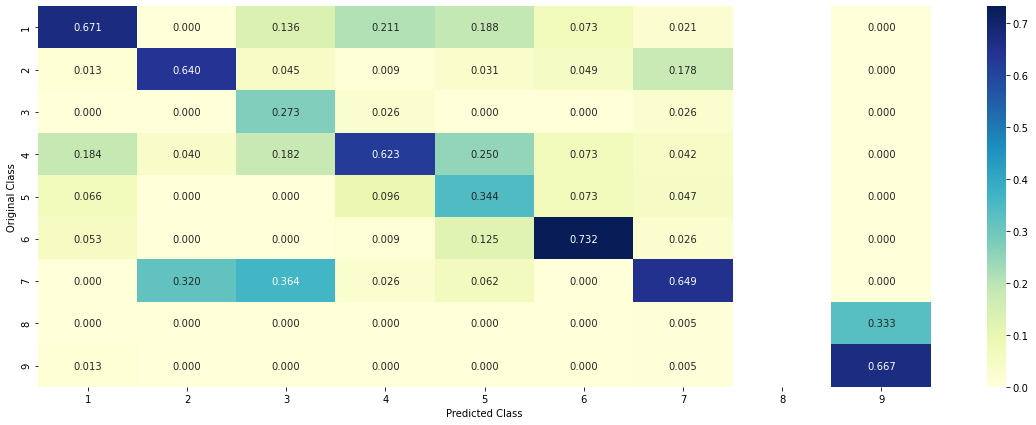

-------------------- Recall matrix (Row sum=1) --------------------


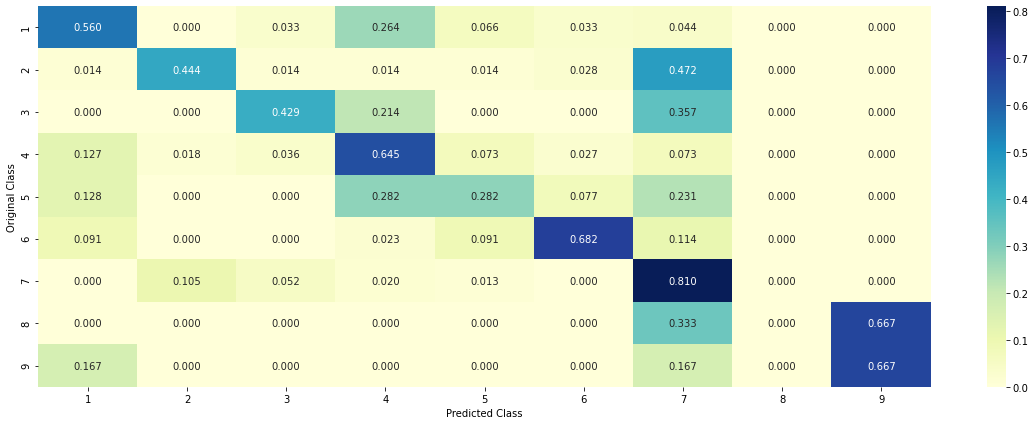

In [195]:
# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

- Feature Importance For Correctly classified point (SVM) :

In [196]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1197 0.1496 0.0209 0.1327 0.0558 0.0437 0.463  0.0075 0.0071]]
Actual Class : 7
--------------------------------------------------
106 Text feature [buchdunger] present in test data point [True]
121 Text feature [constitutively] present in test data point [True]
145 Text feature [814] present in test data point [True]
243 Text feature [expressing] present in test data point [True]
380 Text feature [scf] present in test data point [True]
392 Text feature [activating] present in test data point [True]
399 Text feature [technology] present in test data point [True]
458 Text feature [activated] present in test data point [True]
465 Text feature [constitutive] present in test data point [True]
Out of the top  500  features  9 are present in query point


- Feature Importance for incorrectly classified point (SVM) :

In [202]:
test_point_index = 107
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.1753 0.1506 0.0286 0.2269 0.0834 0.0794 0.2335 0.0097 0.0125]]
Actual Class : 5
--------------------------------------------------
Out of the top  500  features  0 are present in query point


__4.7. Random Forest Classifier__

- Hyper paramter tuning (RF & Response Coding) :

In [205]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0251353075173752
for n_estimators = 10 and max depth =  3
Log Loss : 1.6038885334434223
for n_estimators = 10 and max depth =  5
Log Loss : 1.3296372976186408
for n_estimators = 10 and max depth =  10
Log Loss : 2.045082312617667
for n_estimators = 50 and max depth =  2
Log Loss : 1.6382134318937118
for n_estimators = 50 and max depth =  3
Log Loss : 1.4116049926720684
for n_estimators = 50 and max depth =  5
Log Loss : 1.2690223774756662
for n_estimators = 50 and max depth =  10
Log Loss : 1.7824315613513846
for n_estimators = 100 and max depth =  2
Log Loss : 1.5022583155555662
for n_estimators = 100 and max depth =  3
Log Loss : 1.4163705708778918
for n_estimators = 100 and max depth =  5
Log Loss : 1.244541367867166
for n_estimators = 100 and max depth =  10
Log Loss : 1.7592267487458324
for n_estimators = 200 and max depth =  2
Log Loss : 1.4810945565894609
for n_estimators = 200 and max depth =  3
Log Loss : 1.4089964951020328

- Testing model with best hyper parameters (RF & Response Coding) :

Log loss : 1.244541367867166
Number of mis-classified points : 0.40601503759398494
-------------------- Confusion matrix --------------------


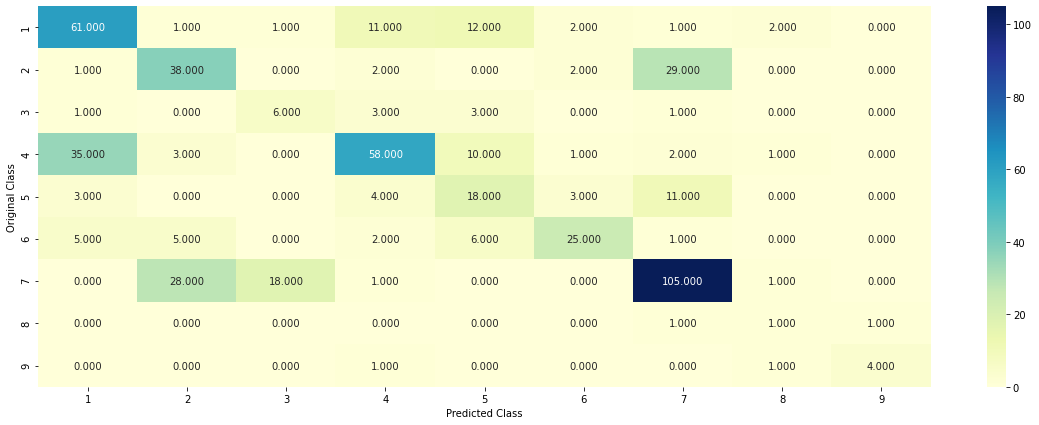

-------------------- Precision matrix (Columm Sum=1) --------------------


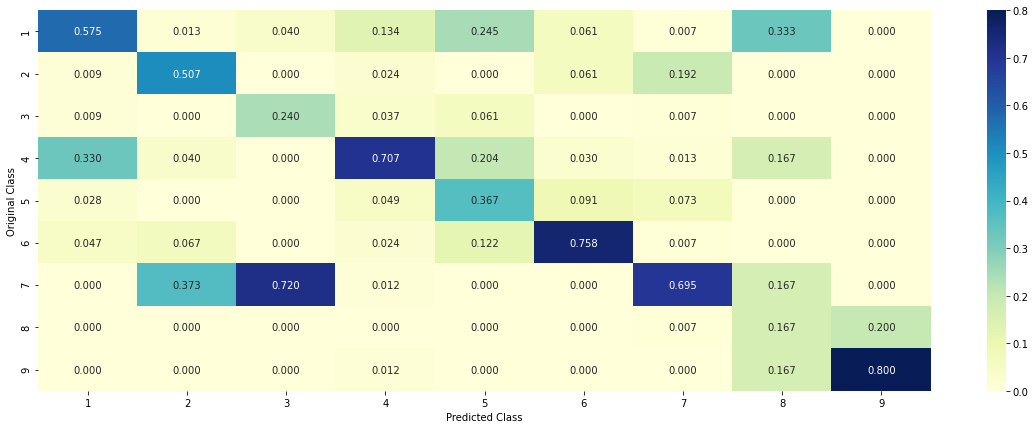

-------------------- Recall matrix (Row sum=1) --------------------


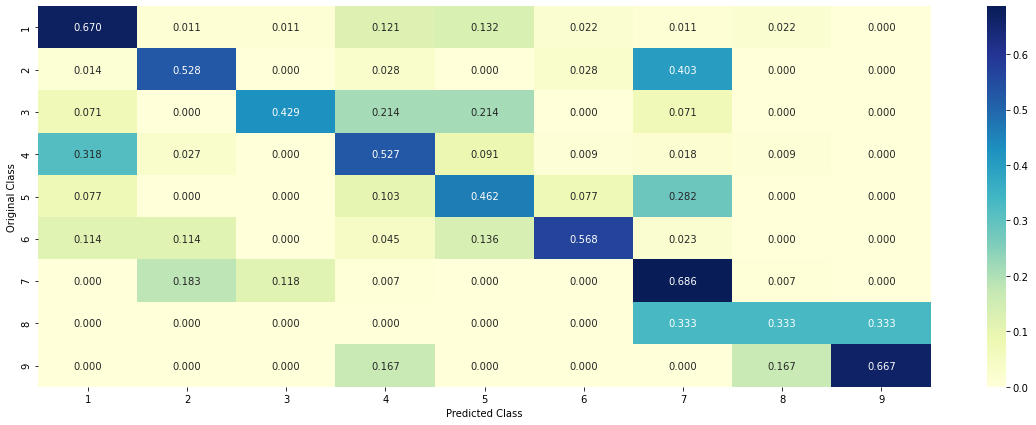

In [206]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto', random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

- Feature Importance for Correctly Classified point (RF & Response Coding) :

In [207]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.feature_importances_)
print("-"*50)

for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0184 0.2853 0.1111 0.0249 0.032  0.0403 0.4458 0.0265 0.0158]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


- Feature Importance for incorrectly Classified point (RF & Response Coding) :

In [209]:
test_point_index = 107
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.feature_importances_)
print("-"*50)

for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.3772 0.0322 0.0852 0.1277 0.0642 0.0871 0.0137 0.1439 0.0687]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


__4.8. Stacking__

- Hyper parameter tuning (Stacking) :

In [210]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))

sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))

sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.14
Support vector machines : Log Loss: 1.68
Naive Bayes : Log Loss: 1.27
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.730
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.360
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.243
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.581
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.946


- Testing the model with the best hyper parameters (Stacking) :

Log loss (train) on the stacking classifier : 0.4992044143767259
Log loss (CV) on the stacking classifier : 1.243299768883577
Log loss (test) on the stacking classifier : 1.0758922284851882
Number of missclassified point : 0.3398496240601504
-------------------- Confusion matrix --------------------


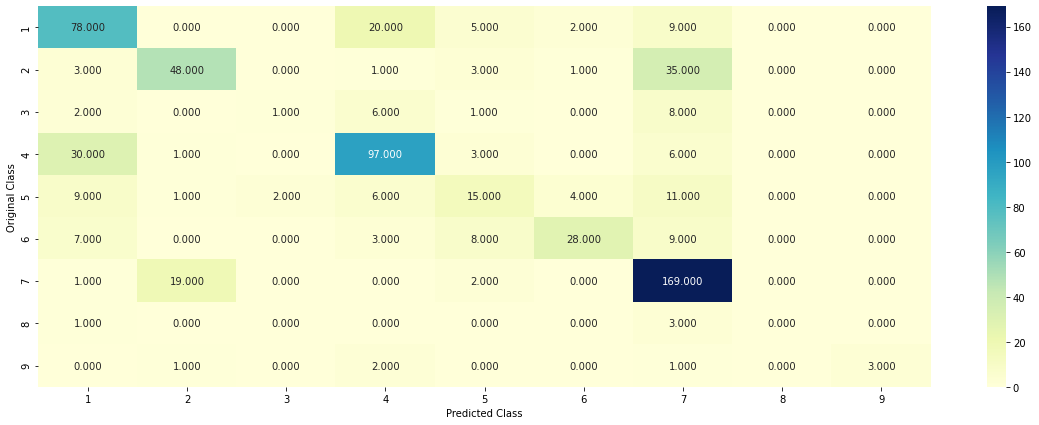

-------------------- Precision matrix (Columm Sum=1) --------------------


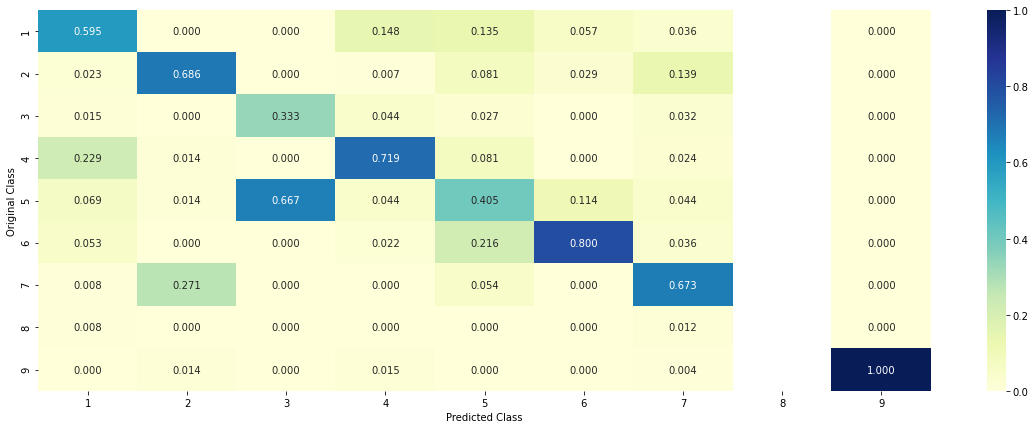

-------------------- Recall matrix (Row sum=1) --------------------


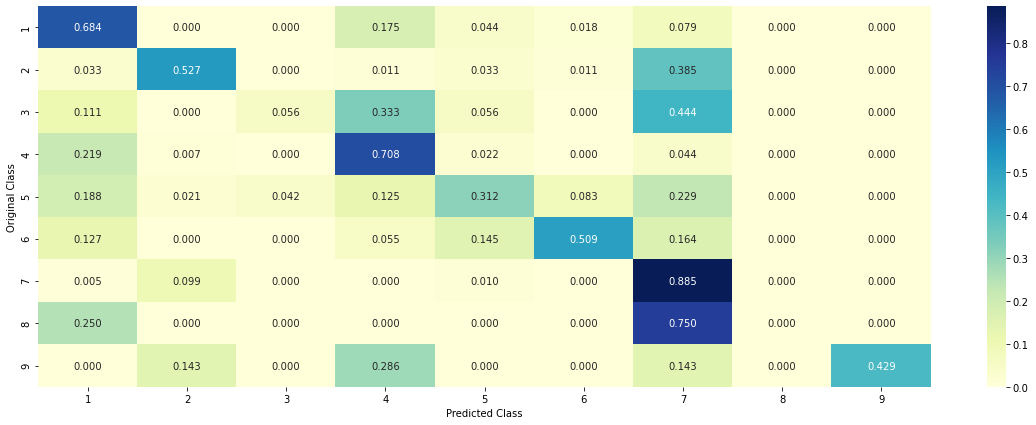

In [211]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :", log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :", log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :", log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

Log loss (train) on the VotingClassifier : 0.8754562788184349
Log loss (CV) on the VotingClassifier : 1.2037721572303333
Log loss (test) on the VotingClassifier : 1.1556162179594491
Number of missclassified point : 0.3323308270676692
-------------------- Confusion matrix --------------------


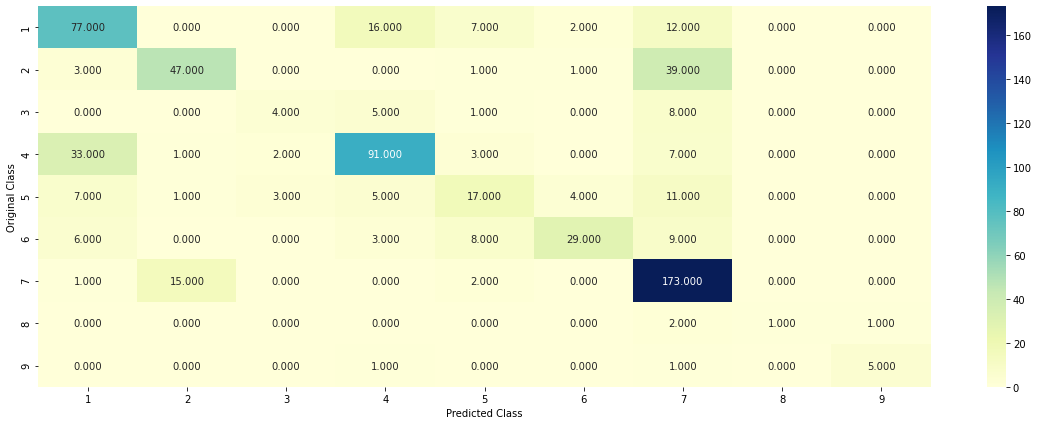

-------------------- Precision matrix (Columm Sum=1) --------------------


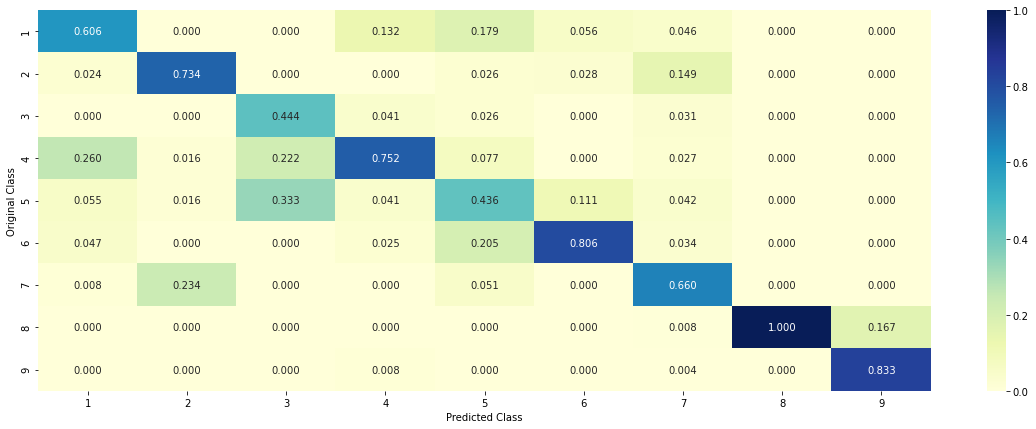

-------------------- Recall matrix (Row sum=1) --------------------


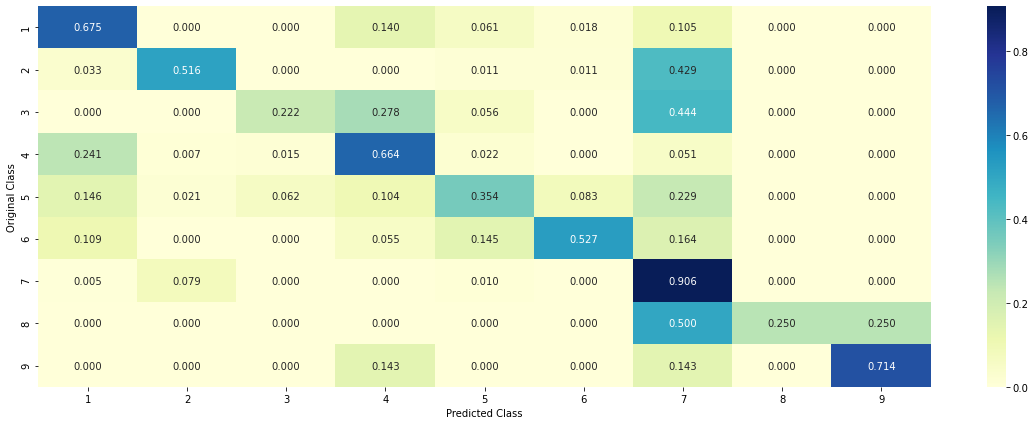

In [213]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)

print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])

plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))